In [19]:
import pandas as pd
from datasets import Dataset

# Load Excel
df1 = pd.read_excel("../data/alarm_ner_dataset_balanced_20000 (2).xlsx")
df2 = pd.read_excel("../data/alarm_ner_dataset_balanced_20000 (1).xlsx")


df = pd.concat([df1,df2], ignore_index=True)

df = df.drop_duplicates().reset_index(drop=True)

# Convert string representation of lists to actual lists
df["tokens"] = df["Tokens"].apply(eval)
df["ner_tags"] = df["NER Tags"].apply(eval)

# Keep only rows where token and tag lengths match
df = df[df["tokens"].str.len() == df["ner_tags"].str.len()].reset_index(drop=True)

# Remove sequences where all tags are "O"
df = df[df["ner_tags"].apply(lambda tags: any(t != "O" for t in tags))].reset_index(drop=True)

# Create tag2id and id2tag mapping
unique_tags = sorted({t for tags in df["ner_tags"] for t in tags})
tag2id = {t:i for i,t in enumerate(unique_tags)}
id2tag = {i:t for t,i in tag2id.items()}

# Convert tags to label IDs
df["labels"] = df["ner_tags"].apply(lambda tags: [tag2id[t] for t in tags])

# Convert to Hugging Face Dataset and split
dataset = Dataset.from_pandas(df[["tokens","labels"]]).train_test_split(test_size=0.1, seed=12)

print(dataset)
print("Train examples:", len(dataset['train']))
print("Test examples:", len(dataset['test']))


DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels'],
        num_rows: 25250
    })
    test: Dataset({
        features: ['tokens', 'labels'],
        num_rows: 2806
    })
})
Train examples: 25250
Test examples: 2806


In [20]:
import torch


In [21]:
from transformers import AutoTokenizer
model_name = "huawei-noah/TinyBERT_General_4L_312D"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )

    word_ids = tokenized_inputs.word_ids()  # Map tokens to original words
    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)  # Special token
        elif word_idx != previous_word_idx:
            label_ids.append(example["labels"][word_idx])
        else:
            # Subsequent subword token
            current_label = example["labels"][word_idx]
            # Convert B- to I- if using BIO scheme
            if current_label < len(tag2id):  # numeric label
                # Only needed if your labels are strings, else keep numeric
                label_ids.append(current_label)
            else:
                label_ids.append(current_label)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs


# Apply the function
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=False)


Map:   0%|          | 0/25250 [00:00<?, ? examples/s]

Map:   0%|          | 0/2806 [00:00<?, ? examples/s]

In [22]:
from transformers import AutoConfig, AutoModelForTokenClassification

# Configure model with dropout
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id,
)


# Load model with this config
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    config=config
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
tokenized_dataset['train'][0]


{'tokens': ['switch', 'evening', 'study', 'tim'],
 'labels': [-100, 8, 3, 1, 5, -100],
 'input_ids': [101, 6942, 3944, 2817, 5199, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [24]:
id2tag

{0: 'B-date',
 1: 'B-label',
 2: 'B-repeat',
 3: 'B-time',
 4: 'I-date',
 5: 'I-label',
 6: 'I-repeat',
 7: 'I-time',
 8: 'O'}

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
import numpy as np

import pandas as pd

history = {}  # history[entity] = {"precision": [], "recall": []}

def compute_metrics(eval_pred):
    global history
    
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=2)

    true_labels, pred_labels = [], []
    for pred_seq, label_seq in zip(predictions, labels):
        for pred, label in zip(pred_seq, label_seq):
            if label != -100:
                true_labels.append(label)
                pred_labels.append(pred)

    true_tags = [id2tag[l] for l in true_labels]
    pred_tags = [id2tag[p] for p in pred_labels]

    from collections import Counter
    counter = Counter(zip(true_tags, pred_tags))
    entity_types = set(true_tags) | set(pred_tags)

    report = {}
    for entity in entity_types:
        tp = counter.get((entity, entity), 0)
        fp = sum(counter.get((other, entity), 0) for other in entity_types if other != entity)
        fn = sum(counter.get((entity, other), 0) for other in entity_types if other != entity)

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

        report[entity] = {"precision": precision, "recall": recall, "f1": f1, "support": tp + fn}

        # Store metrics in history
        if entity not in history:
            history[entity] = {"precision": [], "recall": []}
        history[entity]["precision"].append(precision)
        history[entity]["recall"].append(recall)

    # Macro F1 ignoring 'O'
    macro_f1 = np.mean([report[e]['f1'] for e in entity_types if e != "O"])

    # Optional: print per-class metrics
    df = pd.DataFrame(report).T.round(4)
    print("\nPer-class metrics:\n", df.to_string(), "\n")

    return {"f1": macro_f1, "macro_f1": macro_f1}


In [27]:
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification


args = TrainingArguments(
    output_dir="./NER_bert_model",
    eval_strategy="epoch",         
    learning_rate=2e-5,                   # Slightly higher LR often better for fine-tuning (tune as needed)
    per_device_train_batch_size=16,      
    per_device_eval_batch_size=8,
    num_train_epochs=3,                   # More epochs usually help, unless overfitting
    weight_decay=0.01,
    save_strategy="epoch",                # Save at end of each epoch
    save_total_limit=2,                   # Keep last 2 checkpoints for safety
    load_best_model_at_end=True,          # Load best checkpoint automatically
    metric_for_best_model="macro_f1",     # Select best checkpoint by F1 score
    greater_is_better=True,
    warmup_ratio=0.1,                 
    logging_dir="./logs",
    logging_strategy="epoch",                             
    gradient_accumulation_steps=2,       
    fp16=True                            # Mixed precision training for speed if supported by GPU
)


data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


C:\Users\victus\AppData\Local\Temp\ipykernel_9652\535452104.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [28]:
trainer.train()


g:\model\alarmenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1,Macro F1
1,0.702500,0.140210,0.970063,0.970063
2,0.128500,0.067381,0.984799,0.984799
3,0.079800,0.053492,0.987129,0.987129



Per-class metrics:
           precision  recall      f1  support
B-label      0.9826  0.9725  0.9775   2149.0
I-time       0.9921  0.9937  0.9929   3178.0
O            0.9923  0.9970  0.9946   6431.0
B-repeat     0.9509  0.9869  0.9686    766.0
I-date       0.9335  0.9396  0.9366    613.0
B-date       0.9706  0.8996  0.9338    807.0
I-repeat     0.9819  0.9920  0.9869    874.0
I-label      0.9846  0.9880  0.9863   2328.0
B-time       0.9791  0.9767  0.9779   2015.0 



g:\model\alarmenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Per-class metrics:
           precision  recall      f1  support
B-label      0.9884  0.9874  0.9879   2149.0
I-time       0.9944  0.9981  0.9962   3178.0
O            0.9966  0.9989  0.9977   6431.0
B-repeat     0.9718  0.9896  0.9806    766.0
I-date       0.9571  0.9821  0.9694    613.0
B-date       0.9909  0.9418  0.9657    807.0
I-repeat     0.9977  0.9966  0.9971    874.0
I-label      0.9915  0.9974  0.9944   2328.0
B-time       0.9940  0.9801  0.9870   2015.0 



g:\model\alarmenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Per-class metrics:
           precision  recall      f1  support
B-label      0.9916  0.9874  0.9895   2149.0
I-time       0.9962  0.9972  0.9967   3178.0
O            0.9974  0.9991  0.9982   6431.0
B-repeat     0.9669  0.9909  0.9787    766.0
I-date       0.9711  0.9853  0.9781    613.0
B-date       0.9872  0.9591  0.9730    807.0
I-repeat     0.9954  0.9966  0.9960    874.0
I-label      0.9940  0.9974  0.9957   2328.0
B-time       0.9940  0.9846  0.9893   2015.0 



TrainOutput(global_step=2370, training_loss=0.3036012174710946, metrics={'train_runtime': 103.9016, 'train_samples_per_second': 729.055, 'train_steps_per_second': 22.81, 'total_flos': 32149957546404.0, 'train_loss': 0.3036012174710946, 'epoch': 3.0})

In [31]:
import torch
import string

def predict_ner_bert(text):
    # Encode with offsets for alignment
    text = text.split()  # Split into words for is_split_into_words=True
    encodings = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        return_offsets_mapping=True,
        is_split_into_words=True
    )
    inputs = {k: v.to(model.device) for k, v in encodings.items() if k != "offset_mapping"}

    with torch.no_grad():
        logits = model(**inputs).logits
        pred_ids = torch.argmax(logits, dim=2)[0].cpu().tolist()

    tokens = tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])
    offsets = encodings['offset_mapping'][0].tolist()

    merged_tokens = []
    merged_tags = []

    prev_tag_type = None

    for token, (start, end), tag_id in zip(tokens, offsets, pred_ids):
        # Skip special tokens
        if token in tokenizer.all_special_tokens:
            continue

        tag = id2tag[tag_id]

        # Fix consecutive B- of same type → convert to I-
        if tag.startswith("B-") and tag[2:] == prev_tag_type:
            tag = "I-" + tag[2:]

        # Fix I- without preceding B-
        if tag.startswith("I-") and prev_tag_type != tag[2:]:
            tag = "B-" + tag[2:]

        # Merge subwords correctly
        if token.startswith("##"):
            # Append subword to previous token
            merged_tokens[-1] += token[2:]
            # Keep the previous tag for merged token
            # merged_tags[-1] stays unchanged
        else:
            merged_tokens.append(token)
            merged_tags.append(tag)

        if tag != "O":
            prev_tag_type = tag[2:]
        else:
            prev_tag_type = None

    return list(zip(merged_tokens, merged_tags))


In [32]:
predict_ner_bert("set alarm on 19th december at 7 am for meeting with john")


[('set', 'O'),
 ('alarm', 'O'),
 ('on', 'O'),
 ('19th', 'B-date'),
 ('december', 'I-date'),
 ('at', 'O'),
 ('7', 'B-time'),
 ('am', 'I-time'),
 ('for', 'O'),
 ('meeting', 'B-label'),
 ('with', 'I-label'),
 ('john', 'I-label')]

In [33]:
model.save_pretrained("../models")
tokenizer.save_pretrained("../models")

('../models\\tokenizer_config.json',
 '../models\\special_tokens_map.json',
 '../models\\vocab.txt',
 '../models\\added_tokens.json',
 '../models\\tokenizer.json')

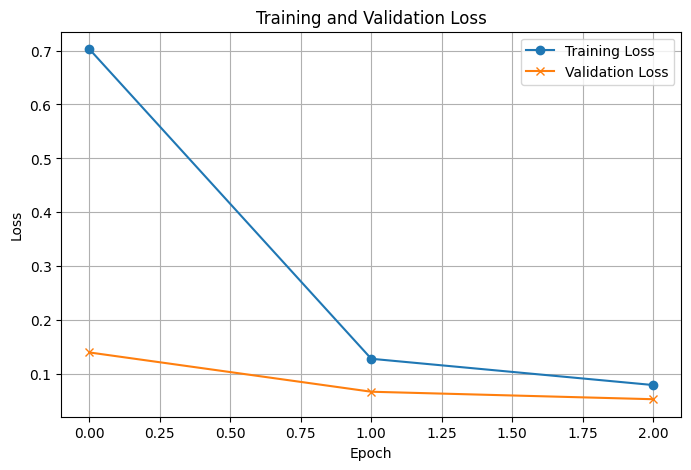

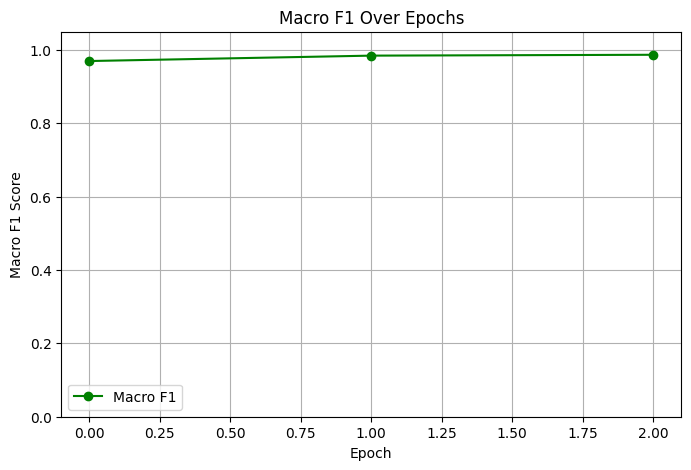

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Extract losses from Trainer's log history
train_losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]
eval_losses = [x["eval_loss"] for x in trainer.state.log_history if "eval_loss" in x]

# Compute macro F1 per epoch from history
macro_f1_history = []
num_epochs = len(eval_losses)  # Assume eval at each epoch
for i in range(num_epochs):
    # Take last precision/recall for each entity at this epoch
    f1s = [2 * (history[e]['precision'][i] * history[e]['recall'][i]) /
           (history[e]['precision'][i] + history[e]['recall'][i]) 
           if (history[e]['precision'][i] + history[e]['recall'][i]) > 0 else 0
           for e in history if e != "O"]
    macro_f1_history.append(np.mean(f1s))

# ---------------------------
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(eval_losses, marker='x', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Plot Macro F1
plt.figure(figsize=(8,5))
plt.plot(macro_f1_history, marker='o', color='green', label="Macro F1")
plt.xlabel("Epoch")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Over Epochs")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()
